In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

ModuleNotFoundError: No module named 'pandas'

In [1]:
quarterly = pd.read_excel('/Users/easydong/DataspellProjects/timeseries/TAF_2_Stationary_Time_Series_PES_quarterly.xls', index_col = 0)
usbond, tbill = quarterly['r5'], quarterly['Tbill']
spread = usbond - tbill
spread.index = pd.to_datetime(spread.index)
spread.index.freq = 'QS-OCT'
spread.head()

NameError: name 'pd' is not defined

In [2]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize= (9, 2*3))
axes[0].plot(spread, color='black', linewidth=1, label='The interest rate spread')
axes[0].hlines(xmin= spread.index[0], xmax=spread.index[-1], y=0,color='gray', linewidth= 1)
axes[0].legend()

#한번 미분한 결과 정상성을 띄우는 걸 볼 수 있음
axes[1].plot(spread.diff(),color='black',linewidth=1,label='First-difference of the spread')
axes[1].hlines(xmin=spread.index[0],xmax=spread. index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()

plt.show()

NameError: name 'plt' is not defined

## ADF test
* null : 시계열이 안정적이지 않다
* alternative : 시계열이 안정적이다

둘다 p-value가 0.05보다 작음
우연히 발생할 확률이 극도로 미미 => null 가설 기각

In [5]:
def adf_test(dataframe):
    result = adfuller(dataframe)
    print(f'Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical values: {result[4]}')

adf_test(spread)
print('---'*40)
adf_test(spread.diff().dropna())

Statistics: -4.702603696655636
p-value: 8.321012504227815e-05
Critical values: {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}
------------------------------------------------------------------------------------------------------------------------
Statistics: -5.688123744797399
p-value: 8.189105600677141e-07
Critical values: {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}


## KPSS test
* null : 시계열이 안정적이다.
* alternative : 시계열이 안정적이지 않다.

미분 안한 spread은 p-value가 0.23으로 0.1보다 커서 귀무가설을 채택하지만
미분한 spread는 0.02로 귀무가설을 기가하므로 non-stationary 하다

In [6]:
def kpss_test(dataframe):
    result = kpss(dataframe)
    print(f'Statistics: {result[0]}')
    print(f'bounded p-value: {result[1]}')
    print(f'Critical values: {result[3]}')

kpss_test(spread)
print('---'*40)
kpss_test(spread.diff().dropna())


Statistics: 0.23250592825595803
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.020995623795567485
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


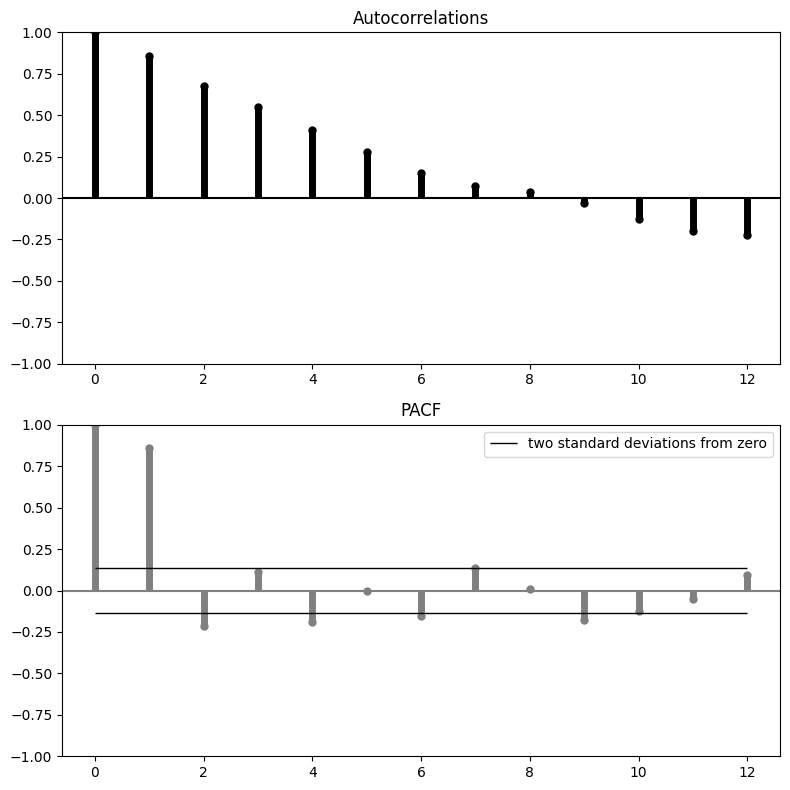

In [7]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,2*4))
plot_acf(spread, lags= 12, ax=axes[0], title='Autocorrelations',
         color = 'black', vlines_kwargs={'colors' : 'black', 'linewidth' : 5}, alpha = None)
plot_pacf(spread, lags=12,ax=axes[1], method='ols', title='PACF', color='gray',
          vlines_kwargs={'colors': 'gray', 'linewidth':5}, alpha=None)

axes[1].hlines(xmin=0,xmax=12,y=2*np.sqrt(1/len(spread)), label='two standard deviations from zero', color='black', linewidth=1)
axes[1].hlines(xmin=0,xmax=12,y=-2*np.sqrt(1/len(spread)), color='black', linewidth=1)

axes[1].legend()
plt.tight_layout()
plt.show()

In [8]:
def get_max_value(element):
    if isinstance(element, int) or isinstance(element, float):
        return element
    else:
        return max(element)

In [9]:
lag_list = [(list(range(1,8)),0,0), (list(range(1,7)), 0, 0), ([1,2],0,0), ([[1,2,7],0,0]),(1,0,1),(2,0,1),(2,0,[1,7])]

summary_table = dict()
idx = 0
num_of_obs = len(spread[7:])


In [10]:
for lag in lag_list:
    temp_perf_dict = {key : key for key in ['SSE','AIC','SBC', 'Q(4)','Q(8)','Q(12)']}

    max_values = [get_max_value(elem) for elem in lag]
    max_element = max(max_values)

    res = ARIMA(endog = spread[7-max_element:], order = lag, trend = 'c').fit(method='innovations_mle')
    temp_perf_dict['SSE'] = round(res.sse,2)
    temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),2)
    temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),2)

    q_statistics = res.test_serial_correlation(method='ljungbox', lags=12)[0]
    temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val': round(q_statistics[1][3],2)}
    temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val': round(q_statistics[1][7],2)}
    temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2), 'p_val': round(q_statistics[1][11],2)}

    for param_name, param in zip(res.params.index, res.params):
        temp_perf_dict[param_name] = {'coef': round(param,2), 't_state': round(res.tvalues[param_name],2)}

    hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']]) # make res. specification['order'] hashable.
    summary_table[hashable_order] = temp_perf_dict


In [11]:
table_2_4 = pd.DataFrame()
for key, value in summary_table.items():
    temp_series = pd.Series(value, name=key)
    table_2_4 = pd.concat([table_2_4,temp_series], axis=1)

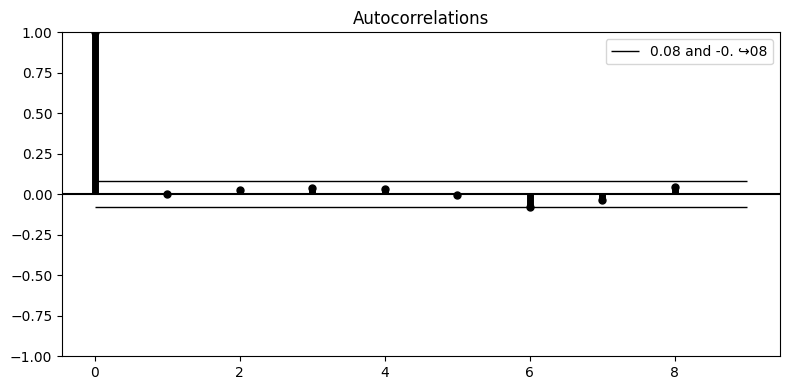

In [12]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

plot_acf(res.resid, lags=8, ax=axes, title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
axes.hlines(xmin=0,xmax=9,y=0.08,label='0.08 and -0. ↪08',color='black',linewidth=1)
axes.hlines(xmin=0,xmax=9,y=-0.08,color='black',linewidth=1)
axes.legend()
plt.tight_layout()
plt.show()

0.13736056394868904

In [61]:
table_2_4.loc[['const','ar.L1','ar.L2','ar.L3','ar.L4','ar.L5','ar.L6','ar.L7','ma.L1','ma.L7','SSE','AIC','SBC','Q(4)','Q(8)','Q(12)'],:]

,"(7, 0, 0)","(6, 0, 0)","(2, 0, 0)","((1, 2, 7), 0, 0)","(1, 0, 1)","(2, 0, 1)","(2, 0, (1, 7))"
const,"{'coef': 1.2, 't_state': 6.33}","{'coef': 1.21, 't_state': 7.24}","{'coef': 1.2, 't_state': 5.79}","{'coef': 1.2, 't_state': 6.53}","{'coef': 1.21, 't_state': 6.23}","{'coef': 1.2, 't_state': 5.62}","{'coef': 1.19, 't_state': 5.74}"
ar.L1,"{'coef': 1.11, 't_state': 15.72}","{'coef': 1.09, 't_state': 17.78}","{'coef': 1.04, 't_state': 18.45}","{'coef': 1.03, 't_state': 16.14}","{'coef': 0.76, 't_state': 14.82}","{'coef': 0.42, 't_state': 3.07}","{'coef': 0.34, 't_state': 3.24}"
ar.L2,"{'coef': -0.44, 't_state': -4.21}","{'coef': -0.42, 't_state': -4.42}","{'coef': -0.22, 't_state': -3.91}","{'coef': -0.2, 't_state': -3.0}",NaN,"{'coef': 0.32, 't_state': 2.48}","{'coef': 0.4, 't_state': 4.18}"
ar.L3,"{'coef': 0.39, 't_state': 4.52}","{'coef': 0.36, 't_state': 4.26}",NaN,NaN,NaN,NaN,NaN
ar.L4,"{'coef': -0.29, 't_state': -3.88}","{'coef': -0.24, 't_state': -3.56}",NaN,NaN,NaN,NaN,NaN
ar.L5,"{'coef': 0.22, 't_state': 2.24}","{'coef': 0.16, 't_state': 2.08}",NaN,NaN,NaN,NaN,NaN
ar.L6,"{'coef': -0.29, 't_state': -2.71}","{'coef': -0.14, 't_state': -2.62}",NaN,NaN,NaN,NaN,NaN
ar.L7,"{'coef': 0.13, 't_state': 1.87}",NaN,NaN,"{'coef': -0.03, 't_state': -0.94}",NaN,NaN,NaN
ma.L1,NaN,NaN,NaN,NaN,"{'coef': 0.38, 't_state': 5.75}","{'coef': 0.7, 't_state': 6.17}","{'coef': 0.78, 't_state': 10.93}"
ma.L7,NaN,NaN,NaN,NaN,NaN,NaN,"{'coef': -0.14, 't_state': -3.73}"


In [62]:
#condition
checker = spread.index <= '2000-04-01'

train_set = spread[checker]
test_set = spread[~checker]

n_train = len(train_set)
n_test = len(test_set)

f1, f1_error = [], []
f2, f2_error = [], []
ground_truth = []

for i in range(n_test):
    crt_time = i + n_train
    x_train = spread[:crt_time]

    model_1 = ARIMA(endog = x_train, order=(7,0,0), trend='c').fit(method='innovations_mle') # model 1
    model_2 = ARIMA(endog = x_train, order=(2,0,[1,7]), trend='c').fit(method='innovations_mle') # model 2

    # one-step-ahead forecasts
    forecast_1 = model_1.forecast(steps=1)
    forecast_2 = model_2.forecast(steps=1)
    # true one-step-ahead value
    y = spread[crt_time]
    ground_truth.append(y)
    f1.append(forecast_1[0])
    f1_error.append(y-forecast_1[0])
    f2.append(forecast_2[0])
    f2_error.append(y-forecast_2[0])





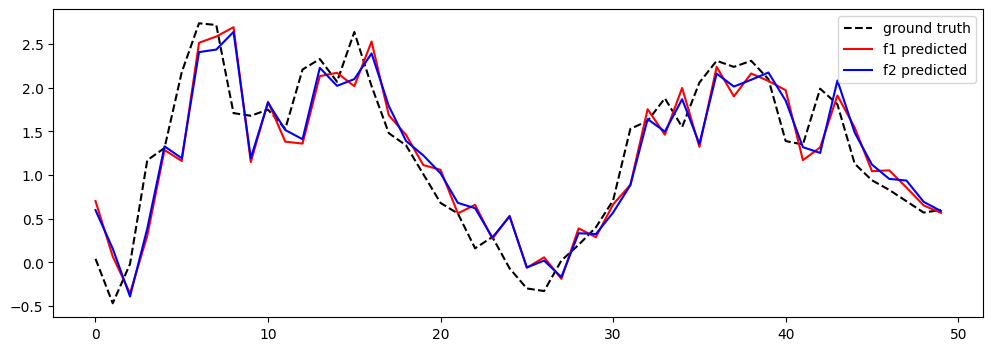

In [63]:
# plot the results
plt.figure(figsize=(12,4))
plt.plot(ground_truth, label='ground truth', color='k', linestyle='--')
plt.plot(f1, label='f1 predicted', color='r')
plt.plot(f2, label='f2 predicted', color='b')
plt.legend()
plt.show()

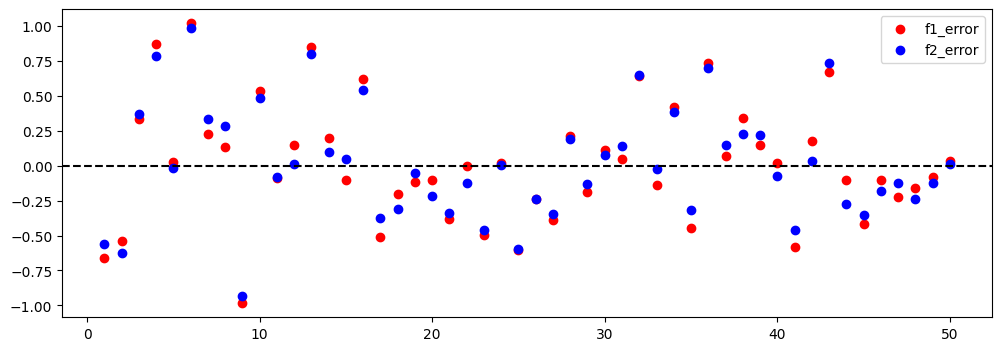

In [64]:
# plot the results
plt.figure(figsize=(12,4))
plt.scatter(np.linspace(1,len(f1_error),len(f1_error)), f1_error, label='f1_error', color='r')
plt.scatter(np.linspace(1,len(f2_error),len(f2_error)), f2_error, label='f2_error', color='b')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.show()

In [65]:
s_2000_3q = ground_truth[0]
f1_2000_3q = f1[0]
f2_2000_3q = f2[0]
f1 = pd.Series(f1)
f2 = pd.Series(f2)
f1_error = pd.Series(f1_error)
f2_error = pd.Series(f2_error)
print(f"Actual value:{round(s_2000_3q,3)}, f1 forecast:{round(f1_2000_3q,3)},f2 forecast:{round(f2_2000_3q,3)}")
print(f"avg f1:{round(np.array(f1).mean(),4)}, avg f2:{round(np.array(f2).mean(),4)}")
print(f"var of f1:{round(np.array(f1).var(),4)}, var of f2:{round(np.array(f2).var(),4)}")
print(f'mean squared prediction error of f1: {round((f1_error**2).mean(),4)},mean squared prediction error of f2: {round((f2_error**2).mean(),4)}')

Actual value:0.04, f1 forecast:0.702,f2 forecast:0.598
avg f1:1.2388, avg f2:1.24
var of f1:0.6155, var of f2:0.5907
mean squared prediction error of f1: 0.1822,mean squared prediction error of f2: 0.1655


In [66]:
# Joint f-test for model 1
dta = pd.concat([pd.Series(f1,name='f1'), pd.Series(ground_truth,name='s')],axis=1)
dta.columns=['f1','s']
formula = 's ~ f1'
results = sm.OLS.from_formula(formula = formula, data = dta).fit()
hypotheses = '(Intercept = 0), (f1 = 1)'
f_test = results.f_test(hypotheses)
print(f_test)
print(results.params)

<F test: F=0.08309504950997434, p=0.9203957568478323, df_denom=48, df_num=2>
Intercept    0.046797
f1           0.973972
dtype: float64


In [67]:
# Joint f-test for model 2
dta = pd.concat([pd.Series(f2,name='f2'), pd.Series(ground_truth,name='s')],axis=1)
dta.columns=['f2','s']
formula = 's ~ f2'
results = sm.OLS.from_formula(formula = formula, data = dta).fit()
hypotheses = '(Intercept = 0), (f2 = 1)'
f_test = results.f_test(hypotheses)
print(f_test)
print(results.params)

<F test: F=0.03155387918048713, p=0.9689588303900432, df_denom=48, df_num=2>
Intercept    0.003444
f2           1.008022
dtype: float64


In [68]:
x_i = f1_error + f2_error
z_i = f1_error - f2_error
corr_xz = x_i.corr(z_i,method='pearson')
Granger_Newbold_stats = corr_xz/ np.sqrt( (1-corr_xz**2)/49 )
print(Granger_Newbold_stats)

1.6836338457891704


In [69]:
d = np.power(f1_error, 4) - np.power(f2_error, 4)
DM = np.mean(d) / np.power(np.var(d) / (len(d) - 1), 0.5)
print(DM)
acf_d = acf(d, nlags=12)[1:]
print(acf_d)

2.4616733900645693
[-0.11346574 -0.12071351  0.27244841  0.06566898  0.3007441  -0.03639365
 -0.01152287  0.08202937  0.08764906  0.00505492 -0.08040521  0.11900986]


In [70]:
m1, m2 = quarterly.M1NSA, quarterly.M2NSA
m1.index , m2.index = pd.to_datetime(m1.index), pd.to_datetime(m2.index)
m1.index.freq = 'QS-OCT'
m2.index.freq = 'QS-OCT'

In [71]:
print('ADF')
adf_test(m1)
print('KPSS')
kpss_test(m1)
print('---'*40)
print('ADF')
adf_test(m2)
print('KPSS')
kpss_test(m2)

ADF
Statistics: 2.200883888498853
p-value: 0.9988832314920305
Critical values: {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}
KPSS
Statistics: 2.1300235888420835
bounded p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
ADF
Statistics: 2.8331907237164735
p-value: 1.0
Critical values: {'1%': -3.4633090972761744, '5%': -2.876029332045744, '10%': -2.5744932593252643}
KPSS
Statistics: 2.042423896605321
bounded p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


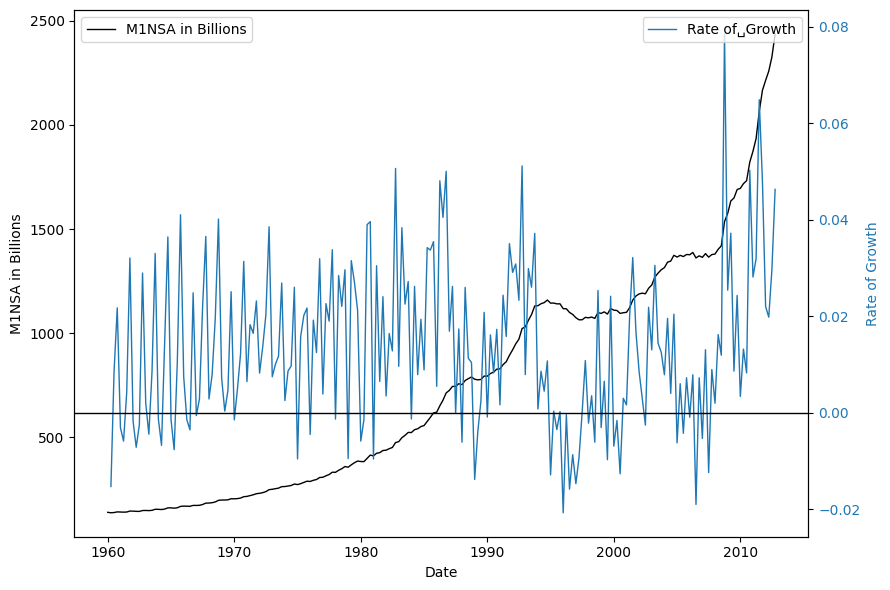

In [72]:
# Figure for M1
fig, ax1 = plt.subplots(figsize=(9, 6))
color = 'black'
ax1.set_xlabel('Date')
ax1.set_ylabel('M1NSA in Billions', color=color)
ax1.plot(m1, color=color, linewidth=1, linestyle='-', label='M1NSA in Billions')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
m1_log_differenced = np.log(m1/m1.shift(1))
ax2.set_ylabel('Rate of Growth', color=color) # we already handled the x-label␣
ax2.plot(np.log(m1/m1.shift(1)), color=color, linewidth=1, label='Rate of␣Growth')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=0, color='black', linewidth=1)
ax2.legend(loc='upper right')
fig.tight_layout() # otherwise the right y-label is slightly clipped plt.show()

In [73]:
print('ADF')
adf_test(m1_log_differenced.dropna())
print('KPSS')
kpss_test(m1_log_differenced.dropna())
print('---'*40)

ADF
Statistics: -3.2391248336053784
p-value: 0.017828777902492748
Critical values: {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}
KPSS
Statistics: 0.15246741424885496
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------


/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


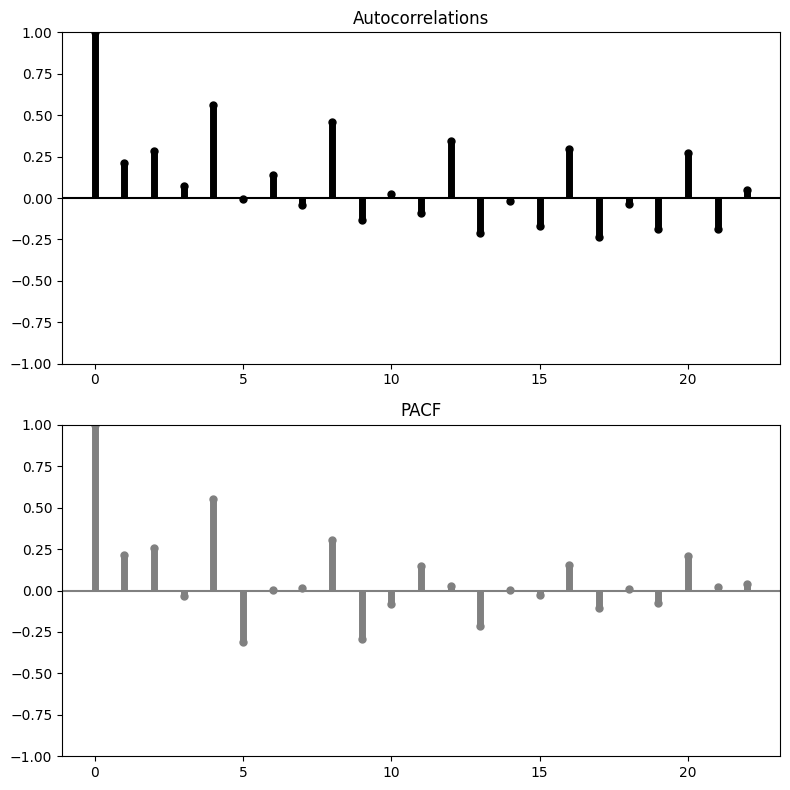

In [74]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(m1_log_differenced.dropna(), lags=22, ax=axes[0],title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(m1_log_differenced.dropna(), lags=22, ax=axes[1], method='ols',title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5},alpha=None)
plt.tight_layout()
plt.show()

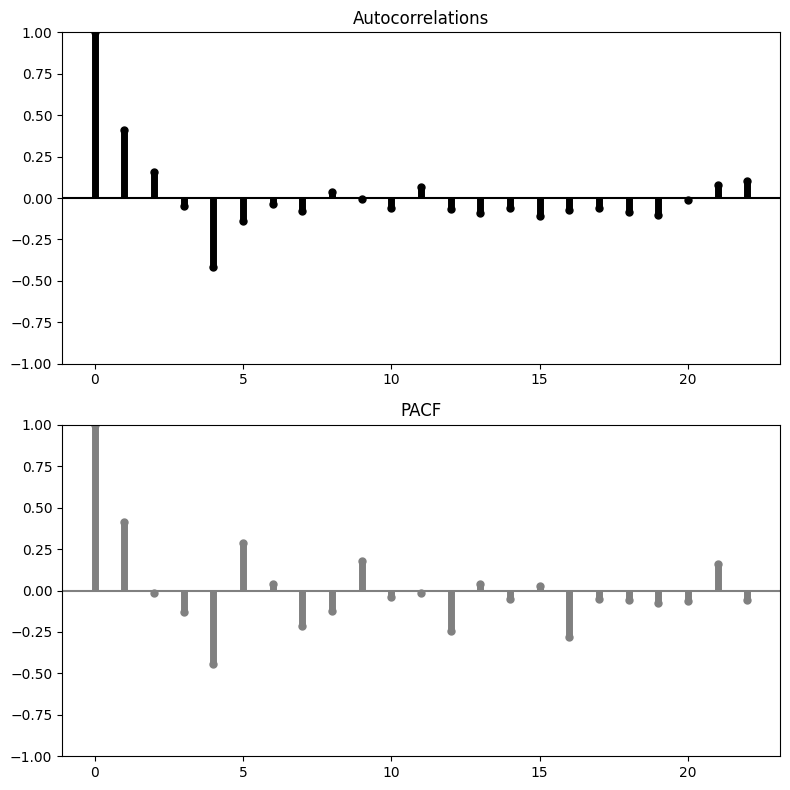

In [75]:
m1_seasonal_difference = np.log(m1/m1.shift(4)).diff().dropna()
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(m1_seasonal_difference, lags=22, ax=axes[0], title='Autocorrelations',color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(m1_seasonal_difference, lags=22, ax=axes[1], method='ols',title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5},alpha=None)
plt.tight_layout()
plt.show()

In [76]:
print('ADF')
adf_test(m1_seasonal_difference)
print('KPSS')
kpss_test(m1_seasonal_difference)
print('---'*40)

ADF
Statistics: -5.196951264040317
p-value: 8.918967291883586e-06
Critical values: {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}
KPSS
Statistics: 0.03430026145196082
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------


/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [77]:
print('ADF')
adf_test(m1_seasonal_difference)
print('KPSS')
kpss_test(m1_seasonal_difference)
print('---'*40)

ADF
Statistics: -5.196951264040317
p-value: 8.918967291883586e-06
Critical values: {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}
KPSS
Statistics: 0.03430026145196082
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------


/Users/easydong/opt/anaconda3/envs/testStudy/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [139]:
# model_1: AR(1) with Seasonal MA term with lag 4
# model_2: Multiplicative Autoregressive
# model_3: Multiplicative Moving Average

#seasonal MA(4)
model_1 = sm.tsa.statespace.SARIMAX(m1_seasonal_difference, trend='c',order=(1, 0, [4])).fit()
model_2 = sm.tsa.statespace.SARIMAX(m1_seasonal_difference, trend='c',order=(1, 0, 0), seasonal_order=(1,0,0,4)).fit()
model_3 = sm.tsa.statespace.SARIMAX(m1_seasonal_difference, trend='c',order=(0, 0, 1), seasonal_order=(0,0,1,4)).fit()
model_2_15_b = sm.tsa.statespace.SARIMAX(m1_seasonal_difference, trend='c',order=(0, 0, 1), seasonal_order=(1,0,0,4)).fit()
summary_table = dict()
idx=0
for model in [model_1, model_2, model_3,model_2_15_b]:
    res = model
# SSE i.e SSR, AIC, SBC, Ljung–Box Q-statistics of the residual␣ ↪autocorrelations for lag:={4, 8, 12}.
    temp_perf_dict = {key: key for key in ['SSE','AIC','SBC','Q(4)','Q(8)','Q(12)']}
# Get the maximum value(s) from each element in the set
    max_values = [get_max_value(elem) for elem in lag]
    max_element = max(max_values)
# We use spread[7-max_element:] to estimate each equation over the␣

    temp_perf_dict['SSE'] = round(res.sse,3)

# Note that since we assume the model errors are IID according to a normal␣ ↪distribution, the BIC and AIC formula is bit different from a general form.
    temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),3)
    temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),3)
# Lijung-box Q-statistics for lag 4,8,12
    q_statistics = res.test_serial_correlation(method='ljungbox',lags=12)[0] #␣ ↪*** Do we have to adjust chi-squared distribution with the degree of freedom? ↪ ***
    temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val':round(q_statistics[1][3],3)}
    temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val':round(q_statistics[1][7],3)}
    temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2),'p_val': round(q_statistics[1][11],3)}
    for param_name, param in zip(res.params.index, res.params): temp_perf_dict[param_name] = {'coef':round(param,3), 't_stats':round(res.tvalues[param_name],3)}
    hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']]) # make res. ↪specification['order'] hashable.
    hashable_s_order = tuple([tuple(s_order) if isinstance(s_order,list) == True else s_order for s_order in res.specification['seasonal_order']]) #␣ ↪make res.specification['order'] hashable.
    summary_table[(hashable_order,hashable_s_order)] = temp_perf_dict

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.04417D+00    |proj g|=  1.07312D+01

At iterate    5    f= -3.04903D+00    |proj g|=  8.38597D-02

At iterate   10    f= -3.04964D+00    |proj g|=  3.65388D+00

At iterate   15    f= -3.05479D+00    |proj g|=  1.27055D+00

At iterate   20    f= -3.05488D+00    |proj g|=  6.31336D-01

At iterate   25    f= -3.05571D+00    |proj g|=  8.38288D+00

At iterate   30    f= -3.06634D+00    |proj g|=  3.53651D+00

At iterate   35    f= -3.06707D+00    |proj g|=  4.15853D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -3.01584D+00    |proj g|=  9.15121D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     46      1     0     0   5.827D-02  -3.016D+00
  F =  -3.0158483939238816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94581D+00    |proj g|=  1.63005D+01

At iterate    5    f= -2.96215D+00    |proj g|=  3.15520D-02

At iterate   10    f= -2.96218D+00    |proj g|=  6.79812D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [140]:
table_2_5 = pd.DataFrame()
for key, value in summary_table.items():
    temp_series = pd.Series(value, name=key)
    table_2_5 = pd.concat([table_2_5,temp_series],axis=1)

In [141]:
table_2_5.loc[['ar.L1','ar.S.L4','ma.L1','ma.L4','ma.S.L4','SSE','AIC','SBC','Q(4)','Q(8)','Q(12)'],:]

,"(((1, 4), 0, (4,)), (0, 0, 0, 0))","((1, 0, 0), (1, 0, 0, 4))","((0, 0, 1), (0, 0, 1, 4))","((0, 0, 1), (1, 0, 0, 4))"
ar.L1,"{'coef': 0.565, 't_stats': 10.886}","{'coef': 0.511, 't_stats': 9.785}",NaN,NaN
ar.S.L4,NaN,"{'coef': -0.522, 't_stats': -8.984}",NaN,"{'coef': -0.461, 't_stats': -7.408}"
ma.L1,NaN,NaN,"{'coef': 0.421, 't_stats': 6.038}","{'coef': 0.405, 't_stats': 6.733}"
ma.L4,"{'coef': -0.761, 't_stats': -12.381}",NaN,NaN,NaN
ma.S.L4,NaN,NaN,"{'coef': -0.714, 't_stats': -13.643}",NaN
SSE,0.026,0.03,0.029,0.032
AIC,-738.012,-712.591,-719.004,-696.073
SBC,-721.397,-699.299,-705.712,-682.781
Q(4),"{'q_stats': 3.98, 'p_val': 0.409}","{'q_stats': 4.82, 'p_val': 0.306}","{'q_stats': 26.88, 'p_val': 0.0}","{'q_stats': 19.1, 'p_val': 0.001}"
Q(8),"{'q_stats': 5.43, 'p_val': 0.711}","{'q_stats': 16.6, 'p_val': 0.035}","{'q_stats': 29.92, 'p_val': 0.0}","{'q_stats': 27.74, 'p_val': 0.001}"
